In [616]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import timesynth as ts
from livelossplot import PlotLosses

import torch
from torch import sigmoid, tanh
from torch.optim import Adam
from torch.nn.functional import mse_loss
from torch.nn import Module, Linear

Using TensorFlow backend.


# Elman RNN

$h_t = \sigma(W_{h} x_t + U_{h} h_{t-1} + b_h)$

$y_t = \sigma(W_{y} h_t + b_y)$

In [630]:
class SimpleRNNCell(Module):
    def __init__(self,
            input_output_size=1,
            hidden_state_size=10):
        super().__init__()
        
        # hidden layer sizes
        self.input_output_size = input_output_size
        self.hidden_state_size = hidden_state_size
        
        self.input_to_hidden_mapping = Linear(self.input_output_size, self.hidden_state_size)
        self.hidden_to_hidden_mapping = Linear(self.hidden_state_size, self.hidden_state_size)
        self.hidden_to_output_mapping = Linear(self.hidden_state_size, self.input_output_size)
        return 
        
    def forward(self, input, hidden_state):
        if hidden_state is None:
            hidden_state = self._get_initial_hidden_states(input.size(0))
        hidden_state = sigmoid(self.input_to_hidden_mapping(input) + self.hidden_to_hidden_mapping(hidden_state))
        output = tanh(self.hidden_to_output_mapping(hidden_state))
        return output, hidden_state
    
    def _get_initial_hidden_states(self, batch_size):
        hidden_state = torch.FloatTensor(batch_size, self.hidden_state_size)
        hidden_state.uniform_(-np.sqrt(1/self.hidden_state_size), np.sqrt(1/self.hidden_state_size))
        return hidden_state

# CTRNN

ODE formulation:

$\tau_{i}\dot{h}_{i,t}=-h_{i}+\sum_{j=1}^{n}w_{j,i}x_{j,t}$

Difference equation formulation:

$h_{i,t+1} = (1 - \frac{1}{\tau}) h_{i,t} + \frac{1}{\tau} \Big( \sum_{j=1}^{n}w_{j,i}x_{j,t} \Big)$

$y_{i,t} = \sigma(h_{i,t})$

In [631]:
class CTRNNCell(Module):
    def __init__(self,
            input_output_size=1,
            hidden_state_size=10,
            tau=10):
        super().__init__()
        
        self.tau = tau
        
        # hidden layer sizes
        self.input_output_size = input_output_size
        self.hidden_state_size = hidden_state_size
        
        self.input_to_hidden_mapping = Linear(self.input_output_size, self.hidden_state_size)
        self.hidden_to_output_mapping = Linear(self.hidden_state_size, self.input_output_size)
        
    def forward(self, input, hidden_state):
        if hidden_state is None:
            hidden_state = self._get_initial_hidden_states(input.size(0))
        hidden_state = (1-1/self.tau) * hidden_state + (1/self.tau) * self.input_to_hidden_mapping(input)
        output = tanh(self.hidden_to_output_mapping(hidden_state))
        return output, hidden_state
    
    def _get_initial_hidden_states(self, batch_size):
        hidden_state = torch.FloatTensor(batch_size, self.hidden_state_size)
        hidden_state.uniform_(-np.sqrt(1/self.hidden_state_size), np.sqrt(1/self.hidden_state_size))
        return hidden_state

# MTRNN

$io_{i,t+1} = (1 - \frac{1}{\tau}) io_{i,t} + \frac{1}{\tau} \Big( 
\sum_{j=1}^{n}w^{xio}_{j,i}x_{j,t} +
\sum_{j=1}^{n}w^{ioio}_{j,i}io_{i,t}
\Big)$

$slow_{i,t+1} = (1 - \frac{1}{\tau}) slow_{i,t} + \frac{1}{\tau} \Big( 
\sum_{j=1}^{n}w^{ss}_{j,i}slow_{j,t} +
\sum_{j=1}^{n}w^{fs}_{j,i}fast_{j,t} 
\Big)$

$fast_{i,t+1} = (1 - \frac{1}{\tau}) fast_{i,t} + \frac{1}{\tau} \Big( 
\sum_{j=1}^{n}w^{ff}_{j,i}fast_{i,t} + 
\sum_{j=1}^{n}w^{sf}_{j,i}slow_{i,t}
\sum_{j=1}^{n}w^{iof}_{j,i}io_{i,t}
\Big)$

$y_{i,t+1} = tanh(io_{i,t})$

In [648]:
class MTRNNCell(Module):
    def __init__(self,
            input_output_size=1,
            input_output_hidden_size=10,
            fast_hidden_size=10,
            slow_hidden_size=5,
            tau_input_output=2,
            tau_fast_hidden=5,
            tau_slow_hidden=70):
        super().__init__()
        
        # hidden layer sizes
        self.input_output_size = input_output_size
        self.input_output_hidden_size =input_output_hidden_size
        self.fast_hidden_size = fast_hidden_size
        self.slow_hidden_size = slow_hidden_size
        
        # decay rates
        self.tau_input_output = tau_input_output
        self.tau_fast_hidden = tau_fast_hidden
        self.tau_slow_hidden = tau_slow_hidden
        
        # linear mappings
        self.input_to_io_mapping = Linear(self.input_output_size, self.input_output_hidden_size)
        self.input_to_fast_mapping = Linear(self.input_output_hidden_size, self.input_output_hidden_size)
        self.fast_to_fast_mapping = Linear(self.fast_hidden_size, self.fast_hidden_size)
        self.fast_to_slow_mapping = Linear(self.fast_hidden_size, self.slow_hidden_size)
        self.slow_to_slow_mapping = Linear(self.slow_hidden_size, self.slow_hidden_size)
        self.slow_to_fast_mapping = Linear(self.slow_hidden_size, self.fast_hidden_size)
        self.fast_to_io_mapping = Linear(self.fast_hidden_size, self.input_output_hidden_size)
        self.io_to_output_mapping = Linear(self.input_output_hidden_size, self.input_output_size)

    def forward(self, input, hidden_states):
        if hidden_states is None:
            hidden_states = self._get_initial_hidden_states(input.size(0))
        io_hidden_state, fast_hidden_state, slow_hidden_state = hidden_states
        
        new_fast_hidden_state = self._update_state(
            previous=fast_hidden_state, 
            new=[self.fast_to_fast_mapping(fast_hidden_state),
                 self.slow_to_fast_mapping(slow_hidden_state),
                 self.input_to_fast_mapping(io_hidden_state)],
            tau=self.tau_fast_hidden)
        
        new_slow_hidden_state = self._update_state(
            previous=slow_hidden_state, 
            new=[self.slow_to_slow_mapping(slow_hidden_state),
                 self.fast_to_slow_mapping(fast_hidden_state)],
            tau=self.tau_slow_hidden)
        
        new_io_hidden_state = self._update_state(
            previous=io_hidden_state, 
            new=[self.fast_to_io_mapping(fast_hidden_state),
                 self.input_to_io_mapping(input)],
            tau=self.tau_slow_hidden)
        
        output = tanh(self.io_to_output_mapping(io_hidden_state))
        hidden_states = (sigmoid(io_hidden_state),
                         sigmoid(new_fast_hidden_state),
                         sigmoid(slow_hidden_state))
        
        return output, hidden_states
        
    def _update_state(self, previous, new, tau):
        new_summed = torch.stack(new)
        new_summed = new_summed.sum(dim=0)
        return (1 - 1/tau) * previous + new_summed/tau
    
    def _get_initial_hidden_states(self, batch_size):
        # Allocate memory
        input_output_hidden_state = torch.FloatTensor(batch_size, self.input_output_hidden_size)
        fast_hidden_state = torch.FloatTensor(batch_size, self.fast_hidden_size)
        slow_hidden_state = torch.FloatTensor(batch_size, self.slow_hidden_size)
        
        # Initialize by sampling uniformly from (-sqrt(1/hidden_size), sqrt(1/hidden_size))
        input_output_hidden_state.uniform_(-np.sqrt(1/self.input_output_hidden_size), np.sqrt(1/self.input_output_hidden_size))
        fast_hidden_state.uniform_(-np.sqrt(1/self.fast_hidden_size), np.sqrt(1/self.fast_hidden_size))
        slow_hidden_state.uniform_(-np.sqrt(1/self.slow_hidden_size), np.sqrt(1/self.slow_hidden_size))
        
        return input_output_hidden_state, fast_hidden_state, slow_hidden_state

In [626]:
class CustomRNN(Module):
    
    def __init__(self, cell=MTRNNCell()):
        super().__init__()
        self.rnn = cell
        
    def forward(self, input, hidden_state=None):
        
        output = torch.empty_like(input)
        for t in range(input.size(0)):
            output[t], hidden_state = self.rnn(input[t], hidden_state)
        return output, hidden_state
            
    
    def generate_synthetic_data(self, input=None, hidden_state=None, sequence_length=100, batch_size=1):
        if hidden_state is None:
            hidden_state = self._get_initial_hidden_states(batch_size)
        if input is None:
            input = torch.zeros(batch_size, self.rnn.input_output_size)
        output = torch.empty(sequence_length, batch_size, self.rnn.input_output_size)
        output[0] = input
        for t in range(1, sequence_length):
            output[t], hidden_state = self.rnn(output[t-1], hidden_state)
        return output

In [627]:
rnn = CustomRNN()
x = torch.FloatTensor(30, 10, 1)
y, h = rnn(x)
assert x.size() == y.size()

In [494]:
def generate_synthetic_data(sequence_length, batch_size, noise_std=0.1):
    time_samples = ts.TimeSampler(stop_time=20).sample_regular_time(num_points=sequence_length)
    sinusoid = ts.signals.Sinusoidal(frequency=0.25)
    white_noise = ts.noise.GaussianNoise(std=noise_std)
    timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
    data = np.ndarray((sequence_length, batch_size), dtype=np.float32)
    for i in range(batch_size):
        samples, signals, errors = timeseries.sample(time_samples)
        data[:, i] = samples
    return data

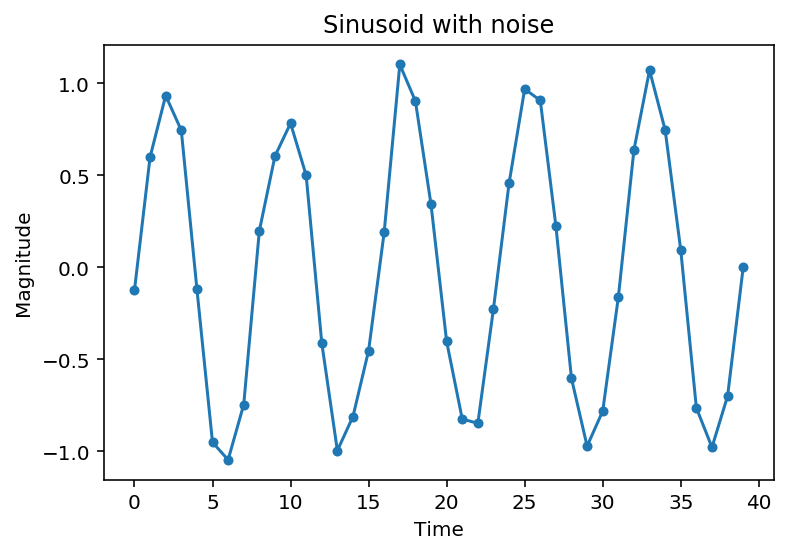

In [489]:
# Plotting sample data
plt.plot(generate_synthetic_data(40, 1), marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Sinusoid with noise');

In [623]:
def train(model):
    optimizer = Adam(params=model.parameters(), lr=1e-4)
    liveloss = PlotLosses()
    for epoch in range(1000):
        train_data = torch.from_numpy(generate_synthetic_data(sequence_length=100, batch_size=16)).unsqueeze(dim=-1)
        output, _ = model(train_data)
        loss = mse_loss(output, train_data)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            liveloss.update({'mse loss': loss})
            liveloss.draw()
            #print(f'Epoch {epoch}, loss: {loss.detach().numpy():.2f}')

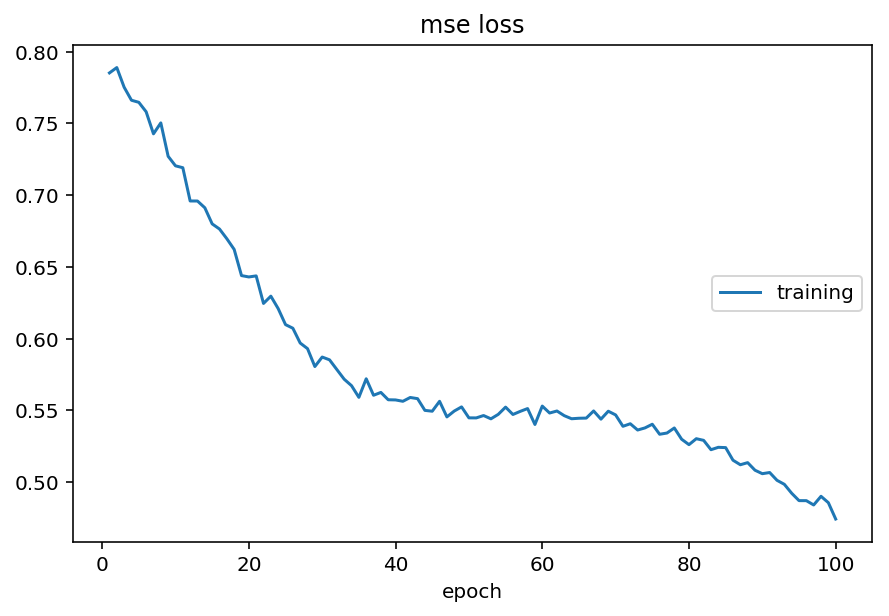

mse loss:
training   (min:    0.474, max:    0.789, cur:    0.474)


In [632]:
rnn = CustomRNN(cell=SimpleRNNCell())
train(rnn)

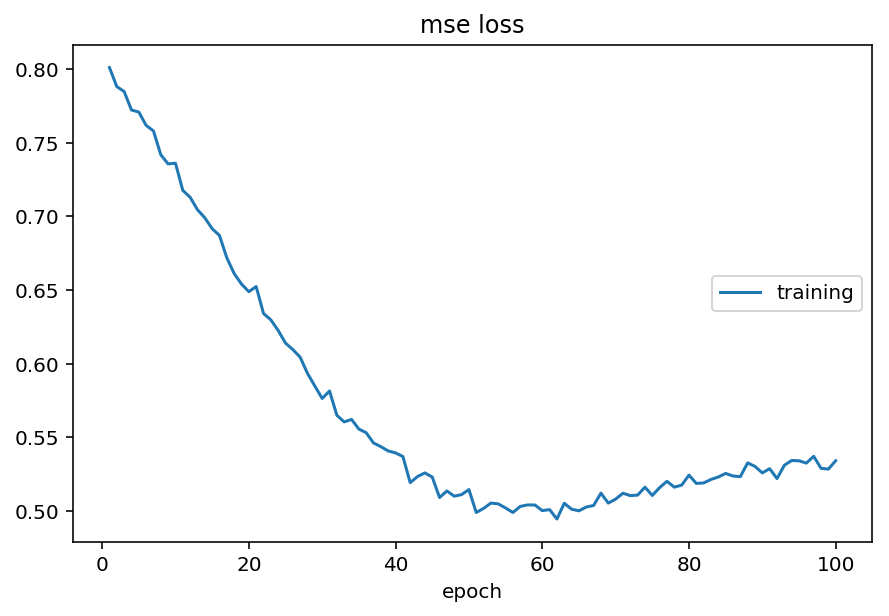

mse loss:
training   (min:    0.495, max:    0.801, cur:    0.534)


In [633]:
rnn = CustomRNN(cell=CTRNNCell())
train(rnn)

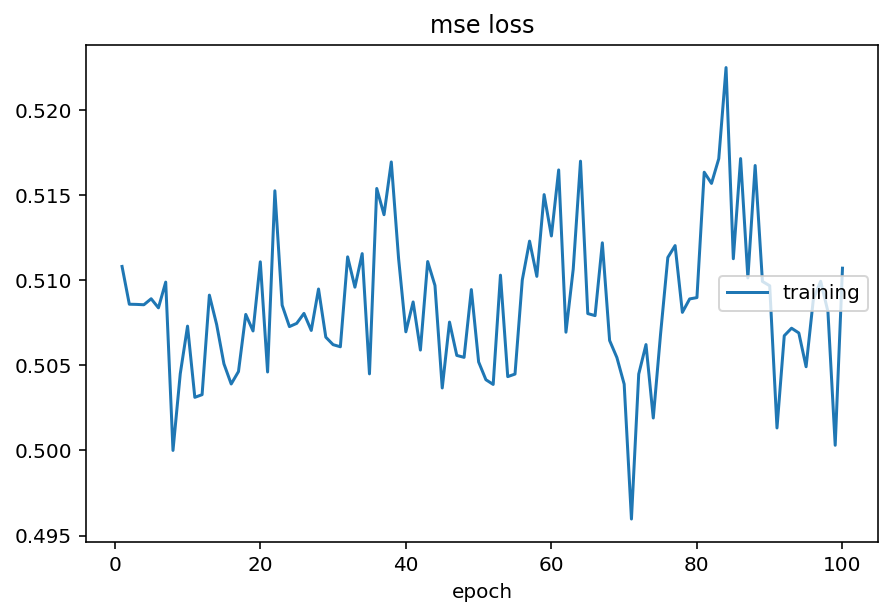

mse loss:
training   (min:    0.496, max:    0.522, cur:    0.511)


In [649]:
rnn = CustomRNN(cell=MTRNNCell())
train(rnn)